# Backtest Environment Parent Class Definition (Godfather part of the code)

In [1]:
from abc import ABC, abstractmethod
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.ndimage.interpolation import shift
from scipy.stats import laplace
import scipy.stats as stats
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore")


class Backtest_Environment(ABC):
    """
    This class contains the methods required to instantiate an environment for creating a backtest strategy. The methods
    include abstract methods, static methods, and normal methods. A child "Strategy" will inherit each of these methods but
    require the definition of 3 abstract methods to become a full strategy. Those methods are:

    - process()
    - monitorPosition()

    The first two contain the entry and exit rules/conditions of the strategy respectively. process() should return the number
    of units to purchase given favourable conditions for creating a position while monitorPosition returns a boolean on whether
    or not a position should be exited.
    backtest() contains the entire for loop logic - all the class functions are brought together here and it is the key function
    to run in order to produce the backtest's results.
    """

    def __init__(self, data, start_cash, pos_size, tc, cooldown=1, max_executions=None, max_execution_period=None,
                 cash_buffer=0, stoploss=None, trailing_stoploss=False):
        self.data = data  # storing the data as a class variable
        self.data = self.format_data(data)  # modifying the data to include columns NDOpen and NDDate
        self.start_cash = int(start_cash)  # storing a specific variable for starting cash
        self.cash_available = start_cash  # storing starting cash in a constantly updated variable
        self.cash_buffer = int(cash_buffer * self.start_cash)  # option buffer amount
        self.cash_time_series = np.array(
            [float(start_cash)])  # initialises a time series of the internal portfolio's cash value
        self.units_held = np.array([int(0)])
        self.openOrders = list()  # list of open orders (for limit order function)
        self.openPositions = list()  # list of open positions
        self.closedPositions = list()  # list of closed positions
        self.shortPositionPrices = defaultdict()  # defaultdict to store short position entry prices
        self.pos_size = pos_size
        self.tc = tc  # transaction costs
        self.cooldown = cooldown  # initialising cooldown to 0 so that a trades can occur
        self.max_executions = max_executions  # maxmium executions
        self.max_execution_period = max_execution_period  # maximum execution period
        self.stoploss = stoploss  # setting the stoploss
        self.trailing_stoploss = trailing_stoploss  # trailing stoploss boolean

        # adding the stoploss to the data
        if self.stoploss is not None:
            self.data["LongStopLoss"] = self.data["Close"] * (1 - self.stoploss)
            self.data["ShortStopLoss"] = self.data["Close"] * (1 + self.stoploss)

        else:
            pass

    @abstractmethod
    def process(self):
        """
        Function that processes the daily input and returns the number of units of the asset that the back-tester should
        purchase given a positive decision.
        If no position is to be taken, the function should return 0.
        """
        pass

    @abstractmethod
    def monitorPosition(self, data, position):
        """
        Takes input of price and position to monitor. Checks if current price is greater than the target price of
        the position.

        Requires input of:
            - position to monitor
            - current price (in the "data" variable - data variable contains row of that day's
            new data)

        The output of running this function is:
            - True if the position has hit it's target and needs to be closed
            - False if the position has not hit it's target and must remain open
        """

        pass

    def backtest(self):
        """
        This function simulates the actions taken on each respective day of the trading strategy.
        The variable "data_row" contains all the necessary trading information to take a decision
        each day.

        Transaction costs are applied in this function depending on whether they are greater than or
        less than 1; the former treated as absolute, the latter as a %.

        Trades Initialised -> Trades Monitored/Updated -> Cash Value Updated
        """

        # start the cooldown value as 0 so trading can commence from day 1
        cooldown = 0

        # initialising a rolling executions variabale
        executions = 0

        # running through each day with all available information required in data_row
        for i in range(0, len(self.data)):

            # all data required for that day's trade processing
            data_row = self.data.iloc[i:i + 1, :]

            # checking if exection max execution period is not None
            if self.max_execution_period is not None:

                # if the current day is a multiple of the max execution period, reset the executions
                if i % self.max_execution_period == 0:
                    executions = 0

            # decrement cooldown as a new day has started - cooldown is the max of 0 and its current value decremented
            # this ensures cooldown never goes below 0
            cooldown = max(0, cooldown - 1)

            # checking if # executions is < max allowed executions
            if self.check_executions(executions):

                # verifying that cooldown period has ended before checking to initialise a trade
                if cooldown == 0:

                    # 1 TRADE INITIALISATION: if a trade is to be placed
                    if self.process(data_row) is not 0:
                        # incrementing executions
                        executions += 1

                        # obtain number of units
                        num_units, pos_type = self.process(data_row)

                        # OPEN a position (market order)
                        if pos_type == "Long":
                            self.openPositions.append(
                                self.openPositionDF(i, data_row.NDOpen.values[0], num_units, data_row.NDDate.values[0],
                                                    pos_type, data_row.PosTarget.values[0],
                                                    data_row.LongStopLoss.values[0]))

                        elif pos_type == "Short":
                            self.openPositions.append(
                                self.openPositionDF(i, data_row.NDOpen.values[0], num_units, data_row.NDDate.values[0],
                                                    pos_type, data_row.PosTarget.values[0],
                                                    data_row.ShortStopLoss.values[0]))

                            # short position entry prices stored in this dictionary
                            self.shortPositionPrices[i] = [data_row.NDOpen.values[0], num_units]

                        # executing the opening of the position - this function alters the self.cash_available variable
                        self.executeOpenPosition(i, data_row, pos_type, num_units)

                        # set the cooldown threshold to the initialised value once a position is opened
                        cooldown = self.cooldown

                        # 2 TRADE MONITORING: monitoring activate trades by
            # creating a false bool that turns true when an order closes
            order_closed = False

            # iterating throughe each open position
            for position in self.openPositions:

                # implementing the trailing stoplosses
                position = self.adjust_trailing_stoploss(data_row, position)

                # checking if exit condition is met in self.monitorPosition()
                if self.monitorPosition(data_row, position) == True:
                    # update order close bool - indicating that an order has closed today
                    order_closed = True

                    # append the closed position to the closed Positions list
                    self.closedPositions.append(
                        self.closePositionDF(position, data_row.NDOpen.values[0], data_row.NDDate.values[0]))

                    # update the status of the open position
                    position = self.changePositionStatus(position)

                    # executing the closing of the position - this function alters the self.cash_available variable
                    self.executeClosePosition(data_row, position)

                    # if an order(s) has closed, remove inactive orders is called
            if order_closed:
                # self.removeInactiveOrders() removes all inactive orders and returns list of only active order
                # result stored in self.openPositions
                self.openPositions = self.removeInactiveOrders()

                # UPDATING CASH
            self.cash_time_series = np.append(self.cash_time_series, self.updatedCash(data_row))
            self.units_held = np.append(self.units_held, self.totalLongUnits())

        # Strategy Statistics: calling the statistics function after the entire test set has been run through
        self.statistics()

        # return
        return True

    def format_data(self, data):
        """
        Strategy agnostic formatting of the data. Adds two columns:
        - NDOpen: Next day open
        - NDDate: Next day date

        In daily strategies decisions are made on this price and this date. This is called inside the constructor of this
        class.
        """

        # STRATEGY AGNOSTIC COLUMNS
        nddate = self.data.index.values[1:]  # tmp array for next day dates
        self.data["NDOpen"] = self.modify_open(data).shift(
            -1)  # next day open: the price on which trade decisions made at the prev close are taken - with a laplacian perturbation added using self.modify_open()
        self.data = self.data.dropna()  # dropping nan to make space for date[1:] values converted into datetime values
        self.data["NDDate"] = pd.to_datetime(
            nddate)  # next day date: the date on which trade decisions made at prev close are taken

        return self.data

    def executeOpenPosition(self, i, data, pos_type, num_units):
        """
        This function changes the self.cash_available value upon the opening of a position by considering the order type,
        and incorporating the relevant transaction costs. It takes the following inputs:

        - i: numerical index of backtest() for loop as a unique order ID
        - data: data_row of that current day containing all relevant market information for strategy
        - pos_type: the type of position - a string reading either Long or Short
        - num_units: the number of units to execute the order with
        """

        if pos_type == "Long":

            # reducing the portfolio's cash for long orders
            if self.tc >= 1:
                self.cash_available = self.cash_available - num_units * data.NDOpen.values[0] - self.tc

            elif self.tc < 1:
                self.cash_available = self.cash_available - num_units * data.NDOpen.values[0] - num_units * \
                                      data.NDOpen.values[0] * self.tc

        elif pos_type == "Short":

            # cash is only adjusted for transaction costs for short positions as cash adjustment taken care of in updatedCash() function
            if self.tc >= 1:
                self.cash_available = self.cash_available - self.tc

            elif self.tc < 1:
                self.cash_available = self.cash_available - (num_units * data.NDOpen.values[0] * self.tc)

    def executeClosePosition(self, data, position):
        """
        This function changes the self.cash_available value upon the closing of a position by considering the order type,
        and incorporating the relevant transaction costs. It takes the following inputs:

        - data: data row for that day containing all the required market data
        - position: the open position that is being closed
        """

        if position.PosType.values[0] == "Long":
            # update cash and charge transaction costs for closing position
            if self.tc >= 1:
                # need to add cash back after absolute transaction costs
                self.cash_available = self.cash_available + position.Units.values[0] * data.NDOpen.values[0] - self.tc

            elif self.tc < 1:
                # need to add cash back after % transaction costs
                self.cash_available = self.cash_available + position.Units.values[0] * data.NDOpen.values[0] - \
                                      position.Units.values[0] * data.NDOpen.values[0] * self.tc

        elif position.PosType.values[0] == "Short":
            # update cash and charge transaction costs for closing position
            if self.tc >= 1:
                # need to add cash back after absolute transaction costs
                self.cash_available = self.cash_available + position.Units.values[0] * (
                            position.EntryPrice.values[0] - data.NDOpen.values[0]) - self.tc

            elif self.tc < 1:
                # need to add cash back after % transaction costs
                self.cash_available = self.cash_available + position.Units.values[0] * (
                            position.EntryPrice.values[0] - data.NDOpen.values[0]) - \
                                      position.Units.values[0] * data.NDOpen.values[0] * self.tc

            # deleting the price from the short position prices (defaultdict used for calculating short position equity changes)
            del self.shortPositionPrices[position.PosID.values[0]]

    def openPositionDF(self, pos_id, price, units, date, pos_type, target_price=None, stoploss=None):
        """
        Standardised function across strategy backtest classes that takes input of:
        - next day's Open price
        - number of units
        - next day's date
        - optional target price

        and returns a dataframe containing all the relevant information contained with an open position.
        To be called within backtest() and created open positions should be appended to self.openPositions.
        """

        # ORDER PARAMETERS
        status = True  # order status
        position_id = pos_id  # position identifier - set to numerical date index
        num_units = units  # units of stock to buy
        entry_price = price
        entry_date = date  # date of purchase
        pos_val = num_units * entry_price  # calculating value of position (pre transaction cost)

        # returning a pandas dataframe
        return pd.DataFrame(
            [[status, pos_type, position_id, num_units, entry_price, entry_date, target_price, stoploss, pos_val]],
            columns=["Status", "PosType", "PosID", "Units", "EntryPrice", "EntryDate", "PosTarget", "StopLoss",
                     "PosVal"])

    def closePositionDF(self, position, price, date):
        """
        Standardised function that takes input of:
            - an open order (dataframe)
            - the next day's open price (day which the transaction is undertaken)
            - the next day's date

        and returns a closed position - which is to be appended to the list self.closedPositions, in class
        method backtest().
        """

        if position["PosType"].values[0] == "Long":
            adjuster = 1

        elif position["PosType"].values[0] == "Short":
            adjuster = -1

        position["Status"] = False  # updating the position status
        position["ExitPrice"] = price  # exit price
        position["ExitDate"] = date  # exit date
        position["CashGainLoss"] = adjuster * position["Units"] * (
                position["ExitPrice"] - position["EntryPrice"])  # calculating cash gain/loss
        position["PercGainPreTC"] = position["CashGainLoss"] / (position["Units"] * position["EntryPrice"])
        position["WinLoss"] = np.sign(position["CashGainLoss"])

        # add more metrics - continue adding over time based on necessary statistics

        return position

    def totalLongUnits(self):
        """
        Function returns total long units held in open positions.
        """

        # counter
        total_units = 0

        # iterating through each open position
        for position in self.openPositions:

            # only add up the units of long positions (since short positions have already been sold)
            if position.PosType.values[0] == "Long":
                # adding up all the units in total units
                total_units += int(position.Units.values[0])

        return int(total_units)

    def totalShortUnits(self):
        """
        Function returns total short units held in open positions.
        """

        # counter
        total_units = 0

        # iterating through each open position
        for position in self.openPositions:

            # only add up the units of long positions (since short positions have already been sold)
            if position.PosType.values[0] == "Short":
                # adding up all the units in total units
                total_units += int(position.Units.values[0])

        return int(total_units)

    def removeInactiveOrders(self):
        """
        Function that iterates through the list of open positions and copies all active positions into a new list
        and updates the class variable to that list i.e. removing all inactive open positions.

        This function works in tandem with self.changePositionStatus() - it is to be run in backtest() after each position
        has been scanned.
        """

        # temporary list to store all active positions
        tmp = []

        # while the size of the open positions list is at least 1
        while len(self.openPositions) >= 1:

            # pop each position off
            position = self.openPositions.pop()

            # if the position is active then store it in the temporary list
            if position.Status.values == True:
                tmp.append(position)

        return tmp

    def updatedCash(self, data):
        """
        Outputs the current cash value of the portfolio by summating the product of the current
        day's close price and the total units held with the available cash after all positions have
        been opened/closed.

        Long positions are accounted for by simplying multiply the total number of long units by the current price since
        the executeOpenPosition subtracts the value of the long position out of the portfolio - this part of the code simply
        adds it back in.

        Only the transaction cost however was subtracted for the short position so only the change in the position needs to
        be calculated. This is done by subtracting the current price from the short position's entry price and multiplying
        by the number of units. The latter 2 variables are stored in a default dictionary called self.shortPositionPrices
        """

        # Calculating current cash value of portfolio

        # taking into account all long positions
        tmp_cash = self.cash_available + (self.totalLongUnits() * data.NDOpen.values[0])

        # calculating the individual changes in the short positions by subtracting the entry price by the current price x units
        # and summating to get the total change - this is why the num_units need to be saved in the defaultdict
        short_change = sum([val[1] * (val[0] - data.NDOpen.values[0]) for val in self.shortPositionPrices.values()])

        # adding the short position changes to the temporary cash variable that holds the long position change
        tmp_cash = tmp_cash + short_change

        return tmp_cash

    def adjust_trailing_stoploss(self, data, position):
        """
        This function implements the trailing stoploss when called with inputs of:
         - data: the current data row in the backtest() for loop
         - position: the position to adjust

         The functions checks whether the position is long or short and adjusts the stoploss accordingly.
        """

        if self.trailing_stoploss == True:

            if position.PosType.values[0] == "Long" and data.Close.values[0] > position.EntryPrice.values[0]:
                position.StopLoss = data.Close.values[0] * (1 - self.stoploss)

            elif position.PosType.values[0] == "Short" and data.Close.values[0] < position.EntryPrice.values[0]:
                position.StopLoss = data.Close.values[0] * (1 + self.stoploss)

        return position

    def check_executions(self, executions):
        """
        Checks if executions are within the limit.
        """

        # verifies if executions equals none, in that case always returns True
        if self.max_executions == None:
            return True

        elif executions < self.max_exections:
            return True

        else:
            return False

    ### STATISTICS FUNCTION
    def statistics(self):
        """
        Calculates and outputs a dataframe containing the full performance statistics of the strategy.
        This function is to be called at the end of backtest() once the entire backtest for loop has been completed.
        """

        # making the cash time series np array into a portfolio time series dataframe indexed by date (useful for calculating VARs)
        self.portfolio_time_series = pd.DataFrame(self.cash_time_series[1:]).set_index(self.data["NDDate"])

        # initialising variables that will be used as counters
        avg_perc_ch = 0
        avg_bars_held = 0
        avg_amount_ch = 0

        winners = 0
        avg_win_bars_held = 0
        avg_winner_perc = 0
        win_prof = 0
        consec_wins = 0
        max_consec_wins = 0
        big_win = 0

        losers = 0
        avg_lose_bars_held = 0
        avg_loser_perc = 0
        lose_prof = 0
        consec_losses = 0
        max_consec_losses = 0
        big_loss = 0

        for position in self.closedPositions:
            avg_perc_ch += position.PercGainPreTC.values[0]
            avg_bars_held += (position.ExitDate[0] - position.EntryDate[0]).days
            avg_amount_ch += position.CashGainLoss.values[0]

            # winner stats calculations
            winners += 1 if position.WinLoss.values[0] == 1 else int(0)
            avg_win_bars_held += (position.ExitDate[0] - position.EntryDate[0]).days if position.WinLoss.values[
                                                                                            0] == 1 else int(0)
            avg_winner_perc += position.PercGainPreTC.values[0] if position.WinLoss.values[0] == 1 else int(0)
            win_prof += position.CashGainLoss.values[0] if position.WinLoss.values[0] == 1 else int(0)
            consec_wins = consec_wins + 1 if (position.WinLoss.values[0] == 1) else int(0)
            max_consec_wins = max(max_consec_wins, consec_wins)
            big_win = max(big_win, position.CashGainLoss.values[0] if position.WinLoss.values[0] == 1 else int(0))

            # loser stats calculations
            losers += 1 if position.WinLoss.values[0] == -1 else int(0)
            avg_lose_bars_held += (position.ExitDate[0] - position.EntryDate[0]).days if position.WinLoss.values[
                                                                                             0] == -1 else int(0)
            avg_loser_perc += position.PercGainPreTC.values[0] if position.WinLoss.values[0] == -1 else int(0)
            lose_prof += position.CashGainLoss.values[0] if position.WinLoss.values[0] == -1 else int(0)
            consec_losses = consec_losses + 1 if position.WinLoss.values[0] == -1 else int(0)
            max_consec_losses = max(max_consec_losses, consec_losses)
            big_loss = min(big_loss, position.CashGainLoss.values[0] if position.WinLoss.values[0] == -1 else int(0))



            # setting an adjuster value to modify the trade time series based on position type
            if position["PosType"].values[0] == "Long":
                pos_time_series = self.data[position.EntryDate.values[0]:position.ExitDate.values[0]]["Open"].values * \
                                  position.Units.values[0]

            elif position["PosType"].values[0] == "Short":
                inv_rets = 1 + (-1 *self.data.loc[position.EntryDate.values[0]:position.ExitDate.values[0]]["Open"].pct_change().dropna())
                inv_rets[0] = self.data[(position.EntryDate-timedelta(days=1)).values[0]:position.ExitDate.values[0]]["Open"][0]
                pos_time_series = inv_rets.cumprod()

            # position specific calculations

            position["Max DD Value"], position["Max DD Return"] = self.__class__.max_dd(pos_time_series)
            position["Holding Time"] = (position.ExitDate[0] - position.EntryDate[0]).days

        self.positions = self.__class__.return_df_of_pos(self.closedPositions)

        # back-test stats
        init_cap = self.cash_time_series[0]
        end_cap = self.cash_time_series[-1]
        total_net_prof = (end_cap - init_cap)
        net_prof_perc = total_net_prof / init_cap
        exposure = self.calc_exposure(self.positions)
        ann_ret = (1 + net_prof_perc) ** (252 / len(self.data)) - 1
        sharpe_ratio = self.__class__.sharpe(self.portfolio_time_series.pct_change().dropna().values)
        sortino_ratio = self.__class__.sortino(self.portfolio_time_series.pct_change().dropna().values)
        trans_costs = self.total_tcost()
        port_max_dd_val, port_max_dd_perc = self.__class__.max_dd(self.cash_time_series)
        one_day_95_var = self.var(self.cash_time_series, 0.95)
        one_day_95_cvar = self.cvar(self.cash_time_series, 0.95)
        one_day_99_var = self.var(self.cash_time_series, 0.99)
        one_day_99_cvar = self.cvar(self.cash_time_series, 0.99)

        # total trade stats
        total_trades = len(self.closedPositions)
        avg_amount_ch = avg_amount_ch / len(self.closedPositions)
        avg_perc_ch = avg_perc_ch / len(self.closedPositions)
        avg_bars_held = avg_bars_held / len(self.closedPositions)
        avg_dd_abs = self.positions["Max DD Value"].mean()
        avg_dd_perc = self.positions["Max DD Return"].mean()
        max_dd_abs = self.positions["Max DD Value"].max()
        max_dd_perc = self.positions["Max DD Return"].min()

        # winner stats
        winners = winners
        win_perc = round(winners / len(self.closedPositions), 2)
        avg_win_prof = win_prof / winners if winners else 0
        avg_winner_perc = avg_winner_perc / winners if winners else 0
        avg_win_bars_held = avg_win_bars_held / winners if winners else 0
        max_consec_wins = max_consec_wins
        big_win_bars_held = (self.positions[self.positions["CashGainLoss"] == big_win].ExitDate - self.positions[
            self.positions["CashGainLoss"] == big_win].EntryDate)[0].days if winners else 0

        # loser stats
        losers = losers
        lose_perc = round(losers / len(self.closedPositions), 2)
        avg_lose_prof = lose_prof / losers if losers else 0
        avg_loser_perc = avg_loser_perc / losers if losers else 0
        avg_lose_bars_held = avg_lose_bars_held / losers if losers else 0
        max_consec_losses = max_consec_losses
        big_loss_bars_held = (self.positions[self.positions["CashGainLoss"] == big_loss].ExitDate - self.positions[
            self.positions["CashGainLoss"] == big_loss].EntryDate)[0].days if losers else 0

        columns = ["Initial Capital", "Ending Capital", "Total Profit", "Total Profit Percentage", "Exposure",
                   "Annual Return", "Annual Sharpe Ratio", "Annual Sortino Ratio", "Transaction Costs", "Portfolio Max DD Value", "Portfolio Max DD Perc",
                   "1 Day 95% VAR", "1 Day 95% CVAR", "1 Day 99% VAR", "1 Day 99% CVAR",
                   "Total Trades", "Avg Gain/Loss", "Avg Percentage Gain/Loss", "Avg Bars Held", "Avg Max DD Value",
                   "Avg Max DD Percentage", "Max DD Trade Value", "Max DD Trade Percentage",
                   "Winners", "Win Percentage", "Win Profits", "Avg Win Profit", "Avg Win Percentage",
                   "Avg Win Bars Held", "Max Consecutive Wins", "Biggest Win", "Biggest Win Bars Held",
                   "Losers", "Lose Percentage", "Loss Losses", "Avg Lose Profit", "Avg Lose Percentage",
                   "Avg Lose Bars Held", "Max Consecutive Losses", "Biggest Loss", "Biggest Loss Bars Held"]

        self.stats = pd.DataFrame([[init_cap, end_cap, total_net_prof, net_prof_perc, exposure, ann_ret, sharpe_ratio, sortino_ratio,
                                    trans_costs, port_max_dd_val, port_max_dd_perc, one_day_95_var, one_day_95_cvar, one_day_99_var,
                                    one_day_99_cvar,
                                    total_trades, avg_amount_ch, avg_perc_ch, avg_bars_held, avg_dd_abs, avg_dd_perc,
                                    max_dd_abs, max_dd_perc,
                                    winners, win_perc, win_prof, avg_win_prof, avg_winner_perc, avg_win_bars_held,
                                    max_consec_wins, big_win, big_win_bars_held,
                                    losers, lose_perc, lose_prof, avg_lose_prof, avg_loser_perc, avg_lose_bars_held,
                                    max_consec_losses, big_loss, big_loss_bars_held]],
                                  columns=columns)

        return

        ### Functions to calculate statistics

    def total_tcost(self):
        """
        Calculates the total transaction costs paid throughout the backtesting of the portfolio.
        """

        total_tc = 0

        if self.tc >= 1:
            # transaction cost for every completed order during opening and closing (hence x2)
            total_tc = (len(self.closedPositions) * 2 * self.tc) + (len(self.openPositions) * self.tc)

        else:
            for position in self.closedPositions:
                total_tc += (position.EntryPrice.values[0] * position.Units.values[0] * self.tc) + (
                        position.ExitPrice.values[0] * position.Units.values[0] * self.tc)

            for position in self.openPositions:
                total_tc += (position.EntryPrice.values[0] * position.Units.values[0] * self.tc)

        return total_tc

    def calc_exposure(self, positions):
        """
        This function calculates the exposure of the trading strategy. It requires the class attribute self.pos_df which contains
        a dataframe with each closed position as a row, holding all the main information regarding that closed position. It returns
        a decimal value for the exposure.
        """

        # maintaining temporary variables for each exposure interval
        curr_exp_start = 0
        curr_exp_end = 0
        curr_exp = 0

        # initialising starting exposure variables
        curr_exp_start = positions.iloc[0, :].EntryDate
        curr_exp_end = positions.iloc[0, :].ExitDate
        curr_exp = int((curr_exp_end - curr_exp_start).days)

        # list for maintaing integers of exposure intervals
        exp_int = []

        for i in range(1, len(positions)):

            # checking if the new position was OPENED BEFORE the closing of the previous position (overlap)
            if positions.iloc[i, :].EntryDate <= positions.iloc[i - 1, :].ExitDate:
                pass

            # condition triggered when new position is OEPNED AFTER the close of the previous position
            # an exposure interval has ended and variables must be re-assigned
            else:

                # appending previous exposure interval to list
                exp_int.append(curr_exp)

                # updating current exposure start and end dates
                curr_exp_start = positions.iloc[i, :].EntryDate
                curr_exp_end = positions.iloc[i, :].ExitDate

                # subtracting weekends
                curr_exp = int((curr_exp_end - curr_exp_start).days) - self.__class__.no_weekends(curr_exp_start,
                                                                                                  curr_exp_end)

            # checking if the new position CLOSED AFTER close of the previous position (extend exposure)
            if positions.iloc[i, :].ExitDate > positions.iloc[i - 1, :].ExitDate:
                curr_exp_end = positions.iloc[i, :].ExitDate

            # condition triggered when new position closes BEFORE close of the previous position
            else:
                pass

        # subtracting weekends and setting exposure equal to sum of exposed periods divided by total days between dataset
        # start and end dates with weekends / non-business days subtracted
        exposure = round(np.sum(exp_int) / (
                int((self.data.index[-1] - self.data.index[0]).days) - self.__class__.no_weekends(
            self.data.index[0], self.data.index[-1])), 2)

        # return exposure as percentage decimal
        return exposure

    def var(self, price_series, alpha):
        """
        Calculates the historical daily value at risk of the portfolio. The steps taken are:
        - calculate the returns of the portfolio
        - sort the returns
        - find the index value closest to the alpha'th return: where alpha corresponds to the var certainty
        - return the VAR value
        """

        # calculate the returns of the portfolio
        p_ret = self.ret(price_series)

        # sort the returns
        sorted_p_ret = np.sort(p_ret)[::-1]

        # find the index value closest to the alpha'th return: where alpha corresponds to the var certainty
        a_idx = int(np.round(alpha * len(p_ret)))

        # VAR value
        Var = sorted_p_ret[a_idx]

        return Var

    def cvar(self, price_series, alpha):
        """
        Calculates the historical daily Conditional Value at Risk (or Expected Shortfall). The steps taken are:
        - calculate the returns of the portfolio
        - sort the returns
        - find the index value closest to the alpha'th return: where alpha corresponds to the var certainty
        - take the average of the values of returns that are below the var value corresponding the alpha'th index
        """
        # calculate the returns of the portfolio
        p_ret = self.ret(price_series)

        # sort the returns
        sorted_p_ret = np.sort(p_ret)[::-1]

        # find the index value closest to the alpha'th return: where alpha corresponds to the var certainty
        a_idx = int(np.round(alpha * len(p_ret)))

        # calculates CVar/Expected Shortfall (ES) by taking the average of the worst 1 - alpha % of cases
        CVar = np.mean(sorted_p_ret[a_idx:])

        return CVar

        ### STATIC METHODS

    @staticmethod
    def changePositionStatus(position):
        """
        Turns a position's status from True to False. Is called whenever an open order is closed.
        """

        position.Status = False

        return position

    @staticmethod
    def modify_open(data, dist="laplace"):
        """
        This function takes in OHLC data and creates a new column in the data called "Modified Open" which alters the open
        price by a small perturbation based on the range of that day and a random variable which is by default a laplacian
        distribution.
        """

        # variables that control the range to scale the data
        r1 = 1
        r2 = -1

        # series of the max deviations in both directions from the open
        s1 = (data["High"] - data["Open"]) / data["Open"]
        s2 = abs(data["Low"] - data["Open"]) / data["Open"]

        # max potential percentage change from open to high or low that day
        raw_perc = pd.concat([s1, s2], axis=1).max(axis=1)

        # generating laplace values
        rvs = getattr(stats, dist).rvs(size=len(raw_perc))  # obtaining the non-scaled variables
        laplace = (rvs - np.min(rvs)) / (np.max(rvs) - np.min(rvs)) * (
                r1 - r2) + r2  # scaling laplace values < 1 and -1 >

        # modelling a modified percentage change
        mod_perc = raw_perc * laplace

        # obtaining modified opens
        mod_open = data["Open"] * (1 + mod_perc)

        return mod_open

    @staticmethod
    def return_df_of_pos(list_of_pos):
        """
        Takes input of a list of positions and returns a dataframe of those positions.
        """

        if len(list_of_pos) == 0:
            return pd.DataFrame()

        # setting positions_dfequal to first closed position dataframe accessed via class variable
        df_of_pos = list_of_pos[0]

        # iterating through each position from the second onwards
        for i, pos in enumerate(list_of_pos, start=1):

            # enumerate goes till i equals the size of list, hence a break condition is in place to trigger on last iteration
            if i == len(list_of_pos): break

            # appending next row to positions_dfdf
            df_of_pos = df_of_pos.append(list_of_pos[i])

            # sorting by date entered
        df_of_pos = df_of_pos.sort_values("EntryDate")

        return df_of_pos

    @staticmethod
    def no_weekends(date1, date2):
        """
        Calculates the number of weekends/ non-business days between two dates.
        """

        # generating dates
        dates = (date1 + timedelta(1 + idx)
                 for idx in range((date2 - date1).days))

        # summing all weekdays
        res = sum(1 for day in dates if day.weekday() < 5)

        # getting number of weekends
        weekends = int((date2 - date1).days) - res

        # return number of weekends / non-business days
        return weekends

    @staticmethod
    def ret(pos_time_series):
        """
        This function takes in a numpy array repreenting a price time series. It outputs the return time series.
        """
        rets = np.delete((shift(pos_time_series, -1) - pos_time_series) / pos_time_series, -1)
        return rets

    @staticmethod
    def sharpe(returns):
        """Takes in numpy array of return values of the portfolio and returns the Sharpe ratio."""

        # calculating sharpe
        sharpe_ratio = np.mean(returns)/np.std(returns)

        return np.round(sharpe_ratio * np.sqrt(252), 3)

    @staticmethod
    def sortino(returns):
        """Takes in numpy array of return values of the portfolio and returns the Sortino ratio."""

        # obtaining negative returns only 
        downside_returns = [ret for ret in returns if ret < 0]
        # calculating sortino
        sortino = np.mean(returns)/np.std(downside_returns)

        return np.round(sortino * np.sqrt(252), 3)

    @staticmethod
    def max_dd(data):
        """
        This function returns the max drawdown of an input price series.
        """

        # obtains the index of the minimum point in the time series
        p = np.argmax(np.maximum.accumulate(data) - data)

        # in the event there is no drawdown
        if p == 0:
            return 0, 0

        else:
            # obtaining the maximum point prior to p
            q = np.argmax(data[:p])

            # calculating the drawdown: absolute value and percentage
            max_dd_abs = np.round(data[q] - data[p], 3)
            max_dd_perc = np.round((data[p] - data[q]) / data[q], 3)

            # returning max drawdown to 3 decimal places
            return max_dd_abs, max_dd_perc

    # ANALYSIS functions: graphs and any other plots
    def exec_per_period(self, period):
        """
        Takes an input of period and outputs the number of executions that occurred every "period" number of days in a block
        by block basis (i.e. not a rolling basis)
        """

        executions_per_period = []
        executions_this_period = 0
        last_week = 0
        pos_idx = 0
        date_idx = []

        for i, date in enumerate(self.data.index):

            if pos_idx == len(self.positions):
                break

            if date == self.positions.iloc[pos_idx, :].EntryDate:
                executions_this_period += 1
                pos_idx += 1

            if i - last_week >= period:
                executions_per_period.append(executions_this_period)
                date_idx.append(date)
                executions_this_period = 0
                last_week = i

        plt.title("Number of executions every {} days".format(period))
        plt.stem(date_idx, executions_per_period)
        plt.grid()

        return

    def trading_mc(self, N, days_to_simulate, pos_ret_q=0):
        """
        This function simulates N Monte Carlo simulations using the historical returns of the trading strategy.

        Inputs:
        - N: number of simulations
        - days_to_simulate: number of days to simulate using historical portfolio returns
        - pos_ret_q: quintile of positive returns that the damping factor is calculated from

        The damping factor is a factor that reduces wins and increases losses by a certain amount. It is set to a quintile of
        the positive returns in this function. This means 1 - pos_ret_q % of returns perform better than the damping factor and
        pos_ret_q % of positive returns are completely reduced, alongside all the losses being increased. It is a stress testing
        factor.
        """

        # dataframe to store simulations
        strategy_mc_simuls = pd.DataFrame()

        # calculating returns dataframe
        returns_df = self.portfolio_time_series.pct_change().dropna()

        # damping factor based on positive returns e.g. reduce all trades by pos_ret_q'th quintile of +ve returns
        damping_factor = returns_df[returns_df >= 0].quantile(pos_ret_q)[
            0]  # 1 - pos_ret_q % of +ve trades do better than this

        # look calculates shuffled return series, shuffles it differently each time, takes cumulative product, and sets first value
        # to the ending value of the strategy, hence simulate "days_to_simulate" # of days from this point using historical strat returns
        for i in range(0, N):
            shuffled = returns_df.sample(
                frac=1 / (len(self.portfolio_time_series) / days_to_simulate))  # shuffles returns
            shuffled = shuffled + 1  # adds one so a meaningful cumprod can be taken
            shuffled = shuffled * (1 - damping_factor)  # adds damping factor
            shuffled.iloc[0] = self.portfolio_time_series.iloc[-1].values[
                0]  # sets first value of col to cumprod to end portfolio value
            shuffled_cumprod = shuffled.cumprod()  # cumulative product
            tmp_df = pd.DataFrame(shuffled_cumprod.values)  # storing one simulation in temporary dataframe
            strategy_mc_simuls = pd.concat([strategy_mc_simuls, tmp_df], axis=1)  # concatenating dataframes

        # appending simulations to MC class variable
        self.MC = self.portfolio_time_series.append(strategy_mc_simuls, ignore_index=True)

        return strategy_mc_simuls

    def plot_MC(self, N, days_to_simulate, pos_ret_q=0):
        """
        This function plots the MC paths, calculated in self.trading_mc(), added onto the previous year of the strategy's
        portfolio time series. The inputs are the same as those in self.trading_mc():

        - N: number of simulations
        - days_to_simulate: number of days to simulate using historical portfolio returns
        - pos_ret_q: quintile of positive returns that the damping factor is calculated from

        """

        # obtain the simulated paths by calling self.trading_mc()
        strategy_mc_simuls = self.trading_mc(N, days_to_simulate, pos_ret_q=0)

        # create an axis for the plot and plot the first path up to the end of the actual portfolio cash time series
        ax = self.MC.iloc[:, 0][:len(self.portfolio_time_series)].plot(figsize=(16, 8), legend=None)

        # plot all the simulated paths
        self.MC[-len(strategy_mc_simuls):].plot(ax=ax, legend=None)
        ax.set_xlim(len(self.portfolio_time_series) - 252)
        ax.set_title("{} Simulated Monte Carlo Strategy Paths".format(N))
        plt.grid()
        plt.show()


# Example Strategy Class Definition (Lieutenant)

In [2]:
class BullHighBreakout(Backtest_Environment):
    
    # first line of arguments contains strategy specific parameters, second line contains backtest environment parameters
    def __init__(self, data, mltv, sttv, start_date, end_date,
                 start_cash, pos_size, tc, cooldown=1, 
                 max_executions=None, max_execution_period=None, cash_buffer=0, stoploss=None, trailing_stoploss=False):
        """
        Constructor method for the strategy child class. Extra arguments specific to the child can be added to this 
        constructor.
        
        The benefit of this is that, strategy specific parameters can be added to this class with the data preparation 
        methods occurring within the class prior to backtest(). 
        
        This structure allows for an easier defintion of new strategies for strategies with the similar rule structures
        but different parameters applied to those rules. 
        """
        
        # Calling the constructor of the parent class - stores input variables + adds strategy agnostic columns to the data
        super().__init__(data, start_cash, pos_size, tc, cooldown, max_executions, max_execution_period, cash_buffer, stoploss, trailing_stoploss)

        # Strategy specific parameters
        self.mltv = mltv
        self.sttv = sttv
        self.start_date = start_date
        self.end_date = end_date
        self.format_strategy_data()
        
    def format_strategy_data(self):
        """
        Prepares data according to the 3 indicators that the strategy requires. The data required is:

        - medium-long term indicator (MLTI): rule 1 - the strategy only initiates a trade when above this value (calculated
        using mltv)
        - short term trade indicator (STTI): rule 2 - the strategy enters positions when the price falls below this value 
        and rule 1 is satisfied (calculated using sttv).
        - position target (PosTarget): rule 3 - the exit conditon relies on this indicator. The strategy exits positions when the 
        price surpasses this value (calculated using sttv). 

        The inputs are:
        - data: any price dataframe containing the columns "Close" and "Open" -
        - mltv: explained above
        - sttv: explained above
        - start_date: self explanatory
        - end_date: self explanatory
        """

        # STRATEGY SPECIFIC COLUMNS
        self.data["MLTI"] = self.data["Close"].rolling(self.mltv).mean() # medium-long term indicator: 200 day moving average
        self.data["STTI"] = self.data["Close"].rolling(self.sttv).mean() # short term trade indicator
        self.data["PosTarget"] = self.data["Close"].rolling(self.sttv).max() # position target: 1 week high

        # accessing dates of interest
        self.data = self.data.loc[self.start_date:self.end_date] # indexing dataframe between the dates of interest once all indicators are calculated
    
    def process(self, data):
        """
        Takes input data which includes: 
        - a Medium to Long Term Indicator (MLTI)
        - a Short Term Trend Indicator (STTI)
        
        in a pandas Dataframe.
        
        This function runs through the logic behind initialising a trade for this strategy. 
        The variable MTLI is a 200 day MA. The variable STTI is a 7 day MA. 
        
        The Logic for opening positions:
        
        - If the price is greater than the MLTI, we proceed
        - If the price is below the 7 day MA (trending low), proceed 
        - If cash after position opens is greater than buffer: 
            - return num_units: indicating output of the decision process is positive, open a position with number
            of units equal to num_units in backtest()
        """
        
        # long term condition satisfied e.g > 200 day MA
        if data.Close.values[0] > data["MLTI"].values[0]:
            
            # short term condition satisfied: < e.g < 7 day MA
            if data.Close.values[0] < data["STTI"].values[0]:
                
                # calculate number of units
                num_units = int(np.floor((self.pos_size * self.cash_available) / data.Close.values[0]))
                
                # return 0 if sufficient cash is not available to buy units at that price
                if num_units == 0:
                    return 0
                
                # cash check - acts as a lid on opening new positions
                if (self.cash_available - num_units*data.Close.values[0]) > self.cash_buffer:
                    
                    return num_units, "Long"
                
                else:
                    return 0
            
        return 0

    def monitorPosition(self, data, position):
        """
        Takes input of price and position to monitor. Checks if current price is greater than the target price of 
        the position. 
        
        Requires input of:
            - position to monitor
            - current price (in the "data" variable - data variable contains row of that day's
            new data)
            
        The output of running this function is: 
            - True if the position has hit it's target and needs to be closed
            - False if the position has not hit it's target and must remain open
        """
        
                
        # checking if current price is greater than the position's target
        if data.Close.values[0] >= position.PosTarget.values[0]:
                    
            # return true
            return True
        
        elif "StopLoss" in position:
            # checking if price is less than stoploss
            if data.Close.values[0] <= position.StopLoss.values[0]:

                # return true
                return True
        
        else:
            return False

## Defining the Strategy Data

In [3]:
# strategy specific parameters
aapl = yf.Ticker("AAPL").history(period="30y")
mltv = 200
sttv = 5
start_date = pd.to_datetime("2016-01-01")
end_date = pd.to_datetime("2021-10-06")

## Instantiating the Strategy and calling the Backtest() function with the desired input parameters

In [4]:
strat = BullHighBreakout(aapl, mltv, sttv, start_date, end_date,
                         start_cash=10000, pos_size=0.1, tc=0.005, cooldown=0, 
                         max_executions=None, max_execution_period=None, cash_buffer=0, 
                         stoploss = 0.1, trailing_stoploss=True)

strat.backtest()

True

## Plotting the portfolio's cash time series

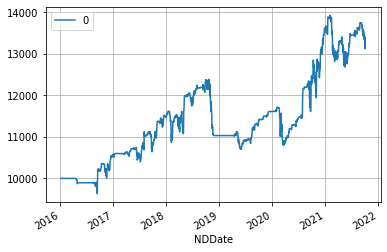

In [5]:
strat.portfolio_time_series.plot()
plt.grid()
plt.show()

## Dataframe read out of all closed positions and their relevant metrics

In [6]:
strat.positions

,Status,PosType,PosID,Units,EntryPrice,EntryDate,PosTarget,StopLoss,PosVal,ExitPrice,ExitDate,CashGainLoss,PercGainPreTC,WinLoss,Max DD Value,Max DD Return,Holding Time
0,False,Long,71,39,25.371116,2016-04-18,25.983170,22.915489,989.473521,22.910315,2016-04-28,-95.971241,-0.096992,-1.0,116.521,-0.118,10
0,False,Long,153,39,25.273013,2016-08-12,25.511604,23.101824,985.647491,25.678779,2016-08-16,15.824904,0.016055,1.0,0.000,0.000,4
0,False,Long,154,35,25.364957,2016-08-15,25.511604,23.101824,887.773478,25.678779,2016-08-16,10.983799,0.012372,1.0,0.000,0.000,1
0,False,Long,160,38,25.443661,2016-08-23,25.645252,23.585046,966.859109,26.633869,2016-09-15,45.227905,0.046778,1.0,52.922,-0.055,23
0,False,Long,161,34,25.455061,2016-08-24,25.640558,23.585046,865.472079,26.633869,2016-09-15,40.079459,0.046309,1.0,47.192,-0.055,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,False,Long,1417,8,147.211026,2021-08-20,151.119995,137.807996,1177.688211,152.558594,2021-08-31,42.780538,0.036326,1.0,18.640,-0.016,11
0,False,Long,1418,7,148.302012,2021-08-23,151.119995,137.807996,1038.114085,152.558594,2021-08-31,29.796070,0.028702,1.0,16.310,-0.016,8
0,False,Long,1421,6,148.277048,2021-08-26,149.710007,137.807996,889.662290,152.558594,2021-08-31,25.689272,0.028875,1.0,5.220,-0.006,5
0,False,Long,1422,6,147.198693,2021-08-27,149.710007,137.807996,883.192160,152.558594,2021-08-31,32.159402,0.036413,1.0,0.000,0.000,4


## Dataframe readout of strategy's full performance statistics

In [7]:
strat.stats.T

,0
Initial Capital,10000.000000
Ending Capital,13396.884188
Total Profit,3396.884188
Total Profit Percentage,0.339688
Exposure,0.700000
Annual Return,0.052100
Annual Sharpe Ratio,0.572000
Annual Sortino Ratio,0.628000
Transaction Costs,3351.751272
Portfolio Max DD Value,1683.764000


## Plotting the number of executions per period of the strategy (risk management)

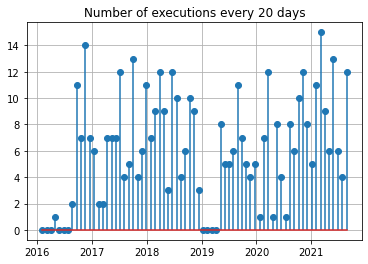

In [8]:
strat.exec_per_period(20)

## Monte Carlo Simulation of Portfolio's Trades

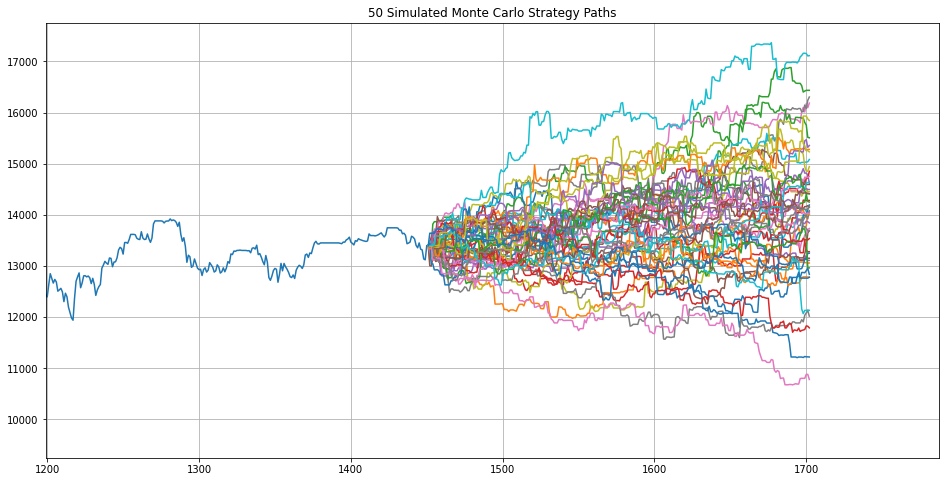

In [9]:
strat.plot_MC(N=50, days_to_simulate=252, pos_ret_q=0)

To do:
- Default buy and hold comparisons
- Probabalistic Sharpe and other ratios 